# critical difference diagram

I want to build a critical difference diagram like [1] with the mvtec table in [2].

[1] Bagnall, A., Lines, J., Bostrom, A., Large, J., Keogh, E., 2017. The great time series classification bake off: a review and experimental evaluation of recent algorithmic advances. Data Min Knowl Disc 31, 606–660. https://doi.org/10.1007/s10618-016-0483-9

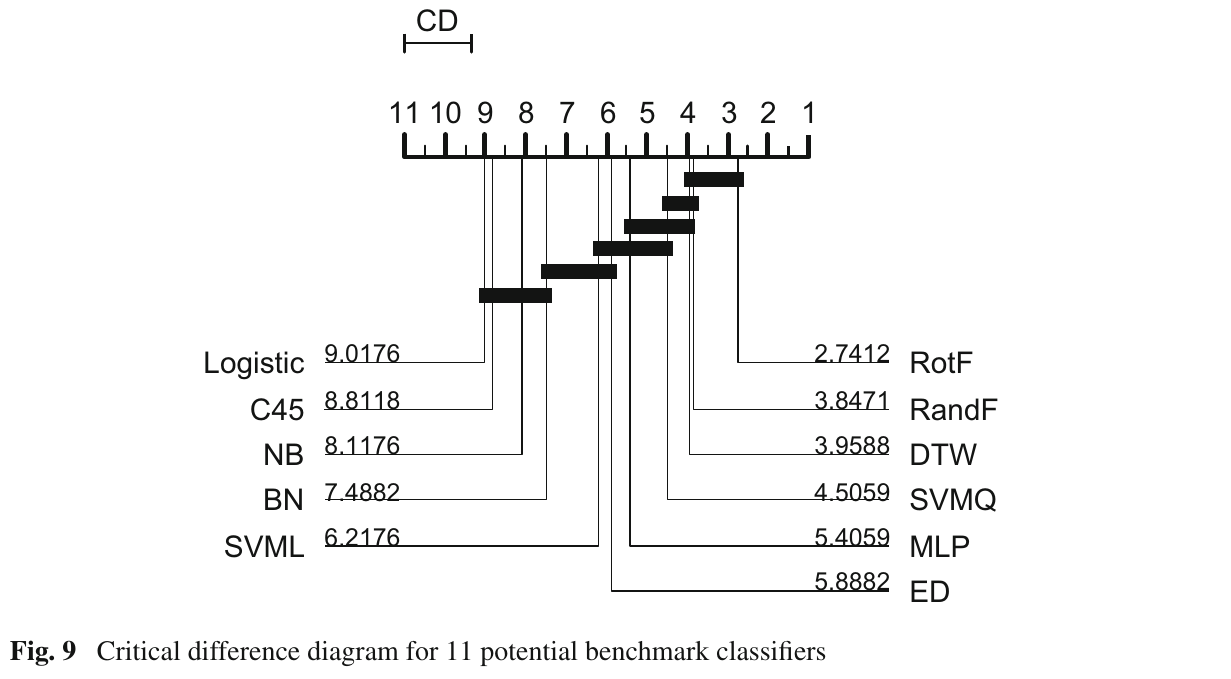


[2] Liznerski, P., Ruff, L., Vandermeulen, R.A., Franks, B.J., Kloft, M., Muller, K.R., 2021. Explainable Deep One-Class Classification, in: International Conference on Learning Representations. Presented at the International Conference on Learning Representations.

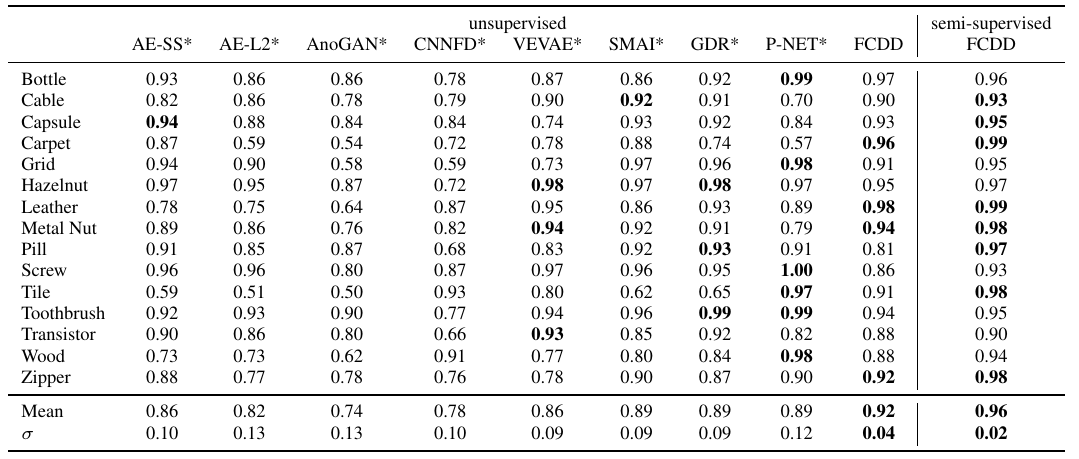

# setup

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [52]:
FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data"
DATA_DIR.mkdir(exist_ok=True)

Let's first check that I have all the runs. 

## data

i create a link to where the data really is in a directory `data` parallel to the notebook

if things are moved away, make the link point to the right place

In [3]:
%pwd
%ls ../../data/results-report-rc2021/

'/home/jcasagrandebertoldo/repos/fcdd/python/analyse'

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/


In [4]:
%mkdir -p data
%cd data
!ln -s ../../../data/results-report-rc2021 
%cd ..

/home/jcasagrandebertoldo/repos/fcdd/python/analyse/data
ln: failed to create symbolic link './results-report-rc2021': File exists
/home/jcasagrandebertoldo/repos/fcdd/python/analyse


In [5]:
%ls data/results-report-rc2021/

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/


## funcs

In [6]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
import copy
from typing import List


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


def get_training_time(path: Path) -> Dict[str, float]:
    """
    The is printed in `log.txt` as 
        START: 21-12-2021 22:46:18 
        DURATION: 1:13:29.009893 
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    
    # simple test
    TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0/log.txt")
    get_training_time(TEST_PATH)
    del TEST_PATH
    """
    DURATION_LINE_REGEX = r"^DURATION: (.+) $"
    DELTA_DATETIME_FORMAT = "%H:%M:%S.%f"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(DURATION_LINE_REGEX, path.read_text(), re.MULTILINE)
    assert search is not None
    delta_str = search.group(1)
    assert delta_str != ""
    # src: https://stackoverflow.com/a/12352624/9582881
    t = datetime.strptime(delta_str, DELTA_DATETIME_FORMAT)
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    assert delta > timedelta(0)
    return {"training_timedelta": delta}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
    ROC_JSON_LISTS = {"tpr", "fpr", "ths"}
    
    with path.open("r") as json_file:
        payload = json.load(json_file)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload


def get_pixelwise_roc(path: Path) -> Dict[str, float]:
    """
    The pixel-wise roc is often lost in mvtec because the images are big so the json
    with all the tpr/fpr/ths would be too big (there's a limit of 10MB somewhere in the code)
    but the pixel-wise ROC-AUC is printed in `log.txt` as like
    ##### GTMAP ROC TEST SCORE 0.9562439079836628 #####
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    """
    # "gtmap" = "pixel-wise" here
    # i got the floating point pattern in stackoverflow
    # src: https://stackoverflow.com/a/12643073/9582881
    GTMAP_ROC_LINE_REGEX = r"##### GTMAP ROC TEST SCORE (([0-9]*[.])?[0-9]+) #####"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(GTMAP_ROC_LINE_REGEX, path.read_text())
    assert search is not None
    val = float(search.group(1))
    assert 1 >= val >= 0
    return {"auc": val}


def experiment_key(experiment_dir: Path) -> str:
    """
    :param experiment_dir: path to the experiment directory
    """
    return f"{experiment_dir.parent.name}.{experiment_dir.name}"


def build_experiment_payload(experiment_dir: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    normal_class_str = experiment_dir.parent.name
    roc_json_path = experiment_dir / "roc.json"
    pixelwise_roc_pdf_path = experiment_dir / "gtmap_roc_curve.pdf"
    print_log_path = experiment_dir / "print.log"
    log_txt_path = experiment_dir / "log.txt"
    
    return {
        "normal_class": normal_class_str,
        "it": experiment_dir.name,
        "dir": experiment_dir,
        "roc_json_path": roc_json_path,
        "normal_class_label": get_class_label(normal_class_str, dataset),
        **get_training_time(log_txt_path),
        **{
            # this is a renaming so sample_roc/pixel_roc won't conflict
            f"sample_roc.{key}": val 
            for key, val in get_roc(roc_json_path).items()
        },
        **(
            {
                f"pixel_roc.{key}": val 
                for key, val in get_pixelwise_roc(print_log_path).items()
            }
            if pixelwise_roc_pdf_path.exists() else
            {}
        )
    }


def get_all_experiments_data(path: Path, dataset: str) -> Dict[str, Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    experiments = {
        (key := experiment_key(iterpath)): {
            **build_experiment_payload(iterpath, dataset=dataset),
            **{"key": key},
        }
        
        # first level: classes
        for dirpath in path.glob("normal_*")
        if dirpath.is_dir()
        
        # second level: iterations
        for iterpath in dirpath.glob("it_*")
        if iterpath.is_dir()
    }
    
    return experiments


# some simple tests
# TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0")
# build_experiment_payload(TEST_PATH, dataset="mvtec")
# del TEST_PATH

# TEST_PATH = Path("../../data/results/mvtec/supervised_merged/")
# all_dicts = get_all_rocs_experiment(TEST_PATH, dataset="mvtec")
# len(all_dicts)
# all_dicts[sorted(all_dicts)[0]]
# del TEST_PATH, all_dicts

# gather data

In [7]:
%ls data/results-report-rc2021/
%ls data/results-report-rc2021/cifar10/
%ls data/results-report-rc2021/mvtec/
%ls data/results-report-rc2021/fmnist/

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/
fcdd_20211221161549_cifar10_@     fcdd_20211221161549_cifar10__HSC@
fcdd_20211221161549_cifar10__AE@
incomplete/  supervised_merged/  unsupervised_merged/
OE-CIFAR100/  OE-EMNIST/


In [8]:
%ls .

001-fmnist-compare.ipynb          005-memory-usage-mvtec-thalassa.ipynb
002-cifar-10-compare.ipynb        006-critical-difference-diagram.ipynb
003-mvtec-compare.ipynb           006-experiments-variability.ipynb
004-cifar-10-training-time.ipynb  data/
004-fmnist-training-time.ipynb    fcdd-memory-usage@
005-memory-usage.ipynb            figs/


In [9]:
DF_FPATH = Path("data") / "006-experiments-variability.df.json"
DF_INDEXNAMES_FPATH = DF_FPATH.parent / f"{DF_FPATH.stem}.index-names.json"

In [76]:
import pandas as pd

try:
    print("loading df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    df = pd.read_json(DF_FPATH).set_index(pd.read_json(DF_INDEXNAMES_FPATH)[0].values.tolist())    
    
except:
    print("couldn't find df, recomputing")
    # variable
    records = {

        # ssup = semi-supervised
        "mvtec-ssup": get_all_experiments_data(
            path=Path("data/results-report-rc2021/mvtec/supervised_merged"), 
            dataset="mvtec"
        ),

        # unsup = unsupervised
        "mvtec-unsup": get_all_experiments_data(
            path=Path("data/results-report-rc2021/mvtec/unsupervised_merged"), 
            dataset="mvtec"
        ),

        "fmnist": get_all_experiments_data(
            path=Path("data/results-report-rc2021/fmnist/OE-CIFAR100/fcdd_20211220193450_fmnist_"), 
            dataset="fmnist"
        ),

        "cifar10": get_all_experiments_data(
            path=Path("data/results-report-rc2021/cifar10/fcdd_20211221161549_cifar10_"), 
            dataset="cifar10"
        ),
    }

    # df = DataFrame
    drop_columns = ["dir", "roc_json_path", "normal_class"]
    dfs = {
        experiment: pd.DataFrame.from_records(data=rec).T \
                        .drop(columns=drop_columns) \
                        .reset_index() \
                        .drop(columns=["index", "key"]) #\
                        .set_index(["normal_class_label", "it"])
        for experiment, rec in records.items()
    }

    exp_keys = sorted(dfs)

    df = pd.concat(
        objs=[dfs[k] for k in exp_keys],
        axis=0,
        keys=exp_keys,
    )
    df.index = df.index.rename(names="experiment", level=0)
    
    print("saving df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    pd.DataFrame(df.index.names).to_json(DF_INDEXNAMES_FPATH)
    df.reset_index().to_json(DF_FPATH)

df.head()

loading df


training_timedelta  \
experiment normal_class_label it                         
cifar10    airplane           it_0             1730000   
                              it_1             1798000   
                              it_2             2090000   
                              it_3             2309000   
                              it_4             2331000   

                                                                       sample_roc.tpr  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [0.0, 0.00011111110000000001, 0.1122222222, 0....   
                              it_1  [0.0, 0.00011111110000000001, 0.1426666667, 0....   
                              it_2  [0.0, 0.00011111110000000001, 0.2076666667, 0....   
                              it_3  [0.0, 0.00011111110000000001, 0.2271111111, 0....   
                              it_4  [0.0, 0.00011111110000000001, 0.1496666667, 0....   

                                                                       sample_roc.fpr  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.002,...   
                              it_1  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_2  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_3  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_4  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   

                                                                       sample_roc.ths  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [51.8181838989, 50.8181838989, 16.0511569977, ...   
                              it_1  [60.8550758362, 59.8550758362, 14.4678506851, ...   
                              it_2  [62.5905227661, 61.5905227661, 12.3422994614, ...   
                              it_3  [53.1703681946, 52.1703681946, 11.7287960052, ...   
                              it_4  [51.9921722412, 50.9921722412, 14.3329000473, ...   

                                    sample_roc.auc  pixel_roc.auc  
experiment normal_class_label it                                   
cifar10    airplane           it_0        0.948551            NaN  
                              it_1        0.945596            NaN  
                              it_2        0.947252            NaN  
                              it_3        0.949191            NaN  
                              it_4        0.948097            NaN

## basic checks

- number of classes
- number of iterations


In [77]:
df.reset_index()[df.index.names].describe()

,experiment,normal_class_label,it
count,250,250,250
unique,4,35,5
top,mvtec-ssup,screw,it_0
freq,75,10,50


In [78]:
df.reset_index().groupby("experiment")[df.index.names[1:]].describe()

normal_class_label                             it               \
                         count unique          top freq count unique   top   
experiment                                                                   
cifar10                     50     10     airplane    5    50      5  it_0   
fmnist                      50     10  t-shirt/top    5    50      5  it_0   
mvtec-ssup                  75     15       bottle    5    75      5  it_0   
mvtec-unsup                 75     15       bottle    5    75      5  it_0   

                  
            freq  
experiment        
cifar10       10  
fmnist        10  
mvtec-ssup    15  
mvtec-unsup   15

In [79]:
df.reset_index().groupby(["experiment", "normal_class_label"])[df.index.names[2:]].describe().T

experiment          cifar10                                                 \
normal_class_label airplane automobile  bird   cat  deer   dog  frog horse   
it count                  5          5     5     5     5     5     5     5   
   unique                 5          5     5     5     5     5     5     5   
   top                 it_0       it_0  it_0  it_0  it_0  it_0  it_0  it_0   
   freq                   1          1     1     1     1     1     1     1   

experiment                      ... mvtec-unsup                                \
normal_class_label  ship truck  ...    hazelnut leather metal_nut  pill screw   
it count               5     5  ...           5       5         5     5     5   
   unique              5     5  ...           5       5         5     5     5   
   top              it_0  it_0  ...        it_0    it_0      it_0  it_0  it_0   
   freq                1     1  ...           1       1         1     1     1   

experiment                                                   
normal_class_label  tile toothbrush transistor  wood zipper  
it count               5          5          5     5      5  
   unique              5          5          5     5      5  
   top              it_0       it_0       it_0  it_0   it_0  
   freq                1          1          1     1      1  

[4 rows x 50 columns]

In [80]:
df.shape

(250, 6)

# paper table

In [124]:
# ############ variable ############
txt_fifle = Path("data/paper-table2-mvtec-perf.txt")  # contains the data part of the table above
str_data = txt_fifle.read_text()
nlines_per_group = 11

# this is in the order of the lines inside each group of 11 lines
METHODS_NAMES = [
    "AE-SS*", "AE-L2*", "Ano-GAN*", "CNNFD*",
    "VEVAE*", "SMAI*", "GDR*", "P-NET*",
    "FCDD-unsupervised", "FCDD-semi-supervised",
]

# ############ fixed ############

lines = str_data.strip().split("\n")
line_groups = [
    lines[(i * nlines_per_group):((i + 1) * nlines_per_group)] 
    for i in range(len(lines) // nlines_per_group)
]

line_groups = [
    {
        "normal_class_label": g[0].lower().replace(" ", "-"),
        **{
            col.lower(): 100 * float(val)
            for col, val in zip(METHODS_NAMES, g[1:])
        },
    }
    for g in line_groups
]
paper_df = pd.DataFrame.from_records(data=line_groups).set_index("normal_class_label")
# manual fix 
paper_df = paper_df.rename(index={"metal-nut": "metal_nut", 'σ': "std"})
paper_df = paper_df.drop(index=["mean", "std"])
paper_df

,ae-ss*,ae-l2*,ano-gan*,cnnfd*,vevae*,smai*,gdr*,p-net*,fcdd-unsupervised,fcdd-semi-supervised
normal_class_label,,,,,,,,,,
bottle,93.0,86.0,86.0,78.0,87.0,86.0,92.0,99.0,97.0,96.0
cable,82.0,86.0,78.0,79.0,90.0,92.0,91.0,70.0,90.0,93.0
capsule,94.0,88.0,84.0,84.0,74.0,93.0,92.0,84.0,93.0,95.0
carpet,87.0,59.0,54.0,72.0,78.0,88.0,74.0,57.0,96.0,99.0
grid,94.0,90.0,58.0,59.0,73.0,97.0,96.0,98.0,91.0,95.0
hazelnut,97.0,95.0,87.0,72.0,98.0,97.0,98.0,97.0,95.0,97.0
leather,78.0,75.0,64.0,87.0,95.0,86.0,93.0,89.0,98.0,99.0
metal_nut,89.0,86.0,76.0,82.0,94.0,92.0,91.0,79.0,94.0,98.0
pill,91.0,85.0,87.0,68.0,83.0,92.0,93.0,91.0,81.0,97.0


# critical difference diagram methodology

screenshots from 

[1] Bagnall, A., Lines, J., Bostrom, A., Large, J., Keogh, E., 2017. The great time series classification bake off: a review and experimental evaluation of recent algorithmic advances. Data Min Knowl Disc 31, 606–660. https://doi.org/10.1007/s10618-016-0483-9

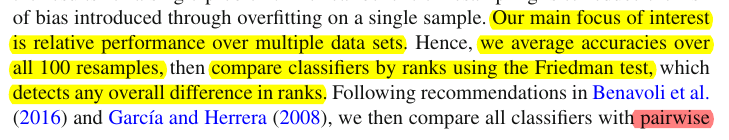

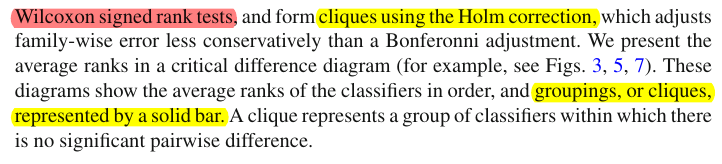

**refs**

Benavoli A, Corani G, Mangili F (2016) Should we really use post-hoc tests based on mean-ranks? J Mach Learn Res 17:1–10

García S, Herrera F (2008) An extension on statistical comparisons of classifiers over multiple data sets for all pairwise comparisons. J Mach Learn Res 9:2677–2694

**keywords**

`pairwise Wilcoxon signed rank tests`, `cliques using the Holm correction`

**internet**

[this seems like a gentle intro](https://www.statisticshowto.com/wilcoxon-signed-rank-test/)

[scipy has wilcoxon test, and the page mentions "pairs"](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

but i found this implementation of critical difference diagram: [hfawaz/cd-diagram](https://github.com/hfawaz/cd-diagram)

In [125]:
%ls ~/repos/cd-diagram/main.py 

/home/jcasagrandebertoldo/repos/cd-diagram/main.py*


In [126]:
!ln -s ~/repos/cd-diagram/main.py cd-diagram.py

ln: failed to create symbolic link 'cd-diagram.py': File exists


In [127]:
%ls .

001-fmnist-compare.ipynb               006-critical-difference-diagram.ipynb
002-cifar-10-compare.ipynb             006-experiments-variability.ipynb
003-mvtec-compare.ipynb                cd-diagram.py@
004-cifar-10-training-time.ipynb       data/
004-fmnist-training-time.ipynb         fcdd-memory-usage@
005-memory-usage.ipynb                 figs/
005-memory-usage-mvtec-thalassa.ipynb


In [131]:
!/home/jcasagrandebertoldo/miniconda3/envs/genv/bin/python cd-diagram.py --help

usage: cd-diagram.py [-h] [--output OUTPUT] [--alpha ALPHA] input

Create a critical difference diagram from `file` and save it in `output_dir`.
The input file should be a .csv with the columns ["model", "dataset",
"metric"]. Metric is assumed to be 'higher is better'.

positional arguments:
  input            Where the input file is

optional arguments:
  -h, --help       show this help message and exit
  --output OUTPUT  Where to output the result. Default is the same dir as the
                   input file with a name "cf-diagram..png".
  --alpha ALPHA    Alpha confidence level for the statistical tests.


## gather data

In [143]:
# cd = critical difference
cd_df_mine = df.loc[["mvtec-unsup", "mvtec-ssup"]] \
             .reset_index().rename(columns={"normal_class_label": "dataset", "experiment": "model", "pixel_roc.auc": "metric"})[["dataset", "model", "metric"]] \
             .groupby(["model", "dataset"])[["metric"]].mean() \
             .reset_index()
cd_df_mine["metric"] = 100 * cd_df_mine["metric"]  # make it %

cd_df_mine.head()
cd_df_mine.shape

,model,dataset,metric
0,mvtec-ssup,bottle,96.686087
1,mvtec-ssup,cable,94.130515
2,mvtec-ssup,capsule,92.948803
3,mvtec-ssup,carpet,98.655946
4,mvtec-ssup,grid,95.204598


(30, 3)

In [178]:
cd_df_paper = paper_df.drop(columns=["fcdd-unsupervised", "fcdd-semi-supervised"]) \
                    .stack().reset_index() \
                    .rename(columns={"normal_class_label": "dataset", "level_1": "model", 0: "metric"})

cd_df_paper.head()
cd_df_paper.shape

,dataset,model,metric
0,bottle,ae-ss*,93.0
1,bottle,ae-l2*,86.0
2,bottle,ano-gan*,86.0
3,bottle,cnnfd*,78.0
4,bottle,vevae*,87.0


(120, 3)

In [181]:
cd_df_mine["model"].unique()

array(['mvtec-ssup', 'mvtec-unsup'], dtype=object)

In [236]:
cd_df = pd.concat([cd_df_paper, cd_df_mine], axis=0)
cd_df = cd_df.replace(dict(model={
    **{label: label.upper() for label in cd_df["model"].unique()},
    # manual corrections
    **{"mvtec-ssup": "FCDD (SS)", "mvtec-unsup": "FCDD (U)"},
}))
cd_df

,dataset,model,metric
0,bottle,AE-SS*,93.000000
1,bottle,AE-L2*,86.000000
2,bottle,ANO-GAN*,86.000000
3,bottle,CNNFD*,78.000000
4,bottle,VEVAE*,87.000000
...,...,...,...
25,tile,FCDD (U),91.442631
26,toothbrush,FCDD (U),92.429742
27,transistor,FCDD (U),87.639549
28,wood,FCDD (U),86.949026


In [237]:
cd_df["model"].unique()

array(['AE-SS*', 'AE-L2*', 'ANO-GAN*', 'CNNFD*', 'VEVAE*', 'SMAI*',
       'GDR*', 'P-NET*', 'FCDD (SS)', 'FCDD (U)'], dtype=object)

## basic checks

- number of classes
- number of iterations


In [238]:
cd_df.describe().T

,count,mean,std,min,25%,50%,75%,max
metric,150.0,86.139196,11.282133,50.0,80.0,90.0,94.0,100.0


In [239]:
cd_df.drop(columns="metric").describe()

,dataset,model
count,150,150
unique,15,10
top,bottle,AE-SS*
freq,10,15


## save

In [240]:
mvtec_cd_fpath = DATA_DIR / "mvtec-critical-difference.csv"
str(mvtec_cd_fpath)
mvtec_cd_fig_fpath = FIGS_DIR / "mvtec-critical-difference.png"
str(mvtec_cd_fig_fpath)

'data/mvtec-critical-difference.csv'

'figs/mvtec-critical-difference.png'

In [241]:
cd_df.to_csv(mvtec_cd_fpath, index=False)

## make cd-diagram

In [242]:
!/home/jcasagrandebertoldo/miniconda3/envs/genv/bin/python cd-diagram.py data/mvtec-critical-difference.csv --alpha 0.10

loading .csv
computing
['AE-SS*' 'AE-L2*' 'ANO-GAN*' 'CNNFD*' 'VEVAE*' 'SMAI*' 'GDR*' 'P-NET*'
 'FCDD (SS)' 'FCDD (U)']
/home/jcasagrandebertoldo/miniconda3/envs/genv/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
AE-L2*       0.0
AE-SS*       1.0
ANO-GAN*     0.0
CNNFD*       0.0
FCDD (SS)    7.0
FCDD (U)     0.0
GDR*         0.0
P-NET*       4.0
SMAI*        0.0
VEVAE*       1.0
dtype: float64
drawing fig
saving


# rankings table

In [260]:
pivot = cd_df.pivot_table(index=["dataset"], columns=["model"], values="metric")
pivot

model,AE-L2*,AE-SS*,ANO-GAN*,CNNFD*,FCDD (SS),FCDD (U),GDR*,P-NET*,SMAI*,VEVAE*
dataset,,,,,,,,,,
bottle,86.0,93.0,86.0,78.0,96.686087,97.007996,92.0,99.0,86.0,87.0
cable,86.0,82.0,78.0,79.0,94.130515,90.547340,91.0,70.0,92.0,90.0
capsule,88.0,94.0,84.0,84.0,92.948803,93.026184,92.0,84.0,93.0,74.0
carpet,59.0,87.0,54.0,72.0,98.655946,96.445884,74.0,57.0,88.0,78.0
grid,90.0,94.0,58.0,59.0,95.204598,91.528274,96.0,98.0,97.0,73.0
hazelnut,95.0,97.0,87.0,72.0,97.118798,95.501949,98.0,97.0,97.0,98.0
leather,75.0,78.0,64.0,87.0,98.680869,98.353175,93.0,89.0,86.0,95.0
metal_nut,86.0,89.0,76.0,82.0,97.471466,93.993337,91.0,79.0,92.0,94.0
pill,85.0,91.0,87.0,68.0,96.755560,83.028246,93.0,91.0,92.0,83.0


In [261]:
sorted_dfs = []

for dataset in pivot.index.values:
    sorted_pivot_line = pivot.loc[[dataset]].sort_values(by=dataset, axis=1)
    sorted_pivot_line = sorted_pivot_line.round(1)
    sorted_pivot_line.loc["model"] = sorted_pivot_line.columns
    sorted_pivot_line = sorted_pivot_line.loc[["model", dataset]]
    sorted_pivot_line.columns = reversed(range(1, len(sorted_pivot_line.columns) + 1))
    sorted_pivot_line = sorted_pivot_line.rename(index={dataset: "Pixel-wise ROC-AUC"})
    sorted_pivot_line = pd.concat({dataset: sorted_pivot_line}, names=["dataset", ""])
    # sorted_pivot_line
    sorted_dfs.append(sorted_pivot_line)

ranking_df = pd.concat(sorted_dfs, axis=0)    
ranking_df

10        9         8          7   \
dataset                                                                  
bottle     model                 CNNFD*    AE-L2*  ANO-GAN*      SMAI*   
           Pixel-wise ROC-AUC      78.0      86.0      86.0       86.0   
cable      model                 P-NET*  ANO-GAN*    CNNFD*     AE-SS*   
           Pixel-wise ROC-AUC      70.0      78.0      79.0       82.0   
capsule    model                 VEVAE*  ANO-GAN*    CNNFD*     P-NET*   
           Pixel-wise ROC-AUC      74.0      84.0      84.0       84.0   
carpet     model               ANO-GAN*    P-NET*    AE-L2*     CNNFD*   
           Pixel-wise ROC-AUC      54.0      57.0      59.0       72.0   
grid       model               ANO-GAN*    CNNFD*    VEVAE*     AE-L2*   
           Pixel-wise ROC-AUC      58.0      59.0      73.0       90.0   
hazelnut   model                 CNNFD*  ANO-GAN*    AE-L2*   FCDD (U)   
           Pixel-wise ROC-AUC      72.0      87.0      95.0       95.5   
leather    model               ANO-GAN*    AE-L2*    AE-SS*      SMAI*   
           Pixel-wise ROC-AUC      64.0      75.0      78.0       86.0   
metal_nut  model               ANO-GAN*    P-NET*    CNNFD*     AE-L2*   
           Pixel-wise ROC-AUC      76.0      79.0      82.0       86.0   
pill       model                 CNNFD*    VEVAE*  FCDD (U)     AE-L2*   
           Pixel-wise ROC-AUC      68.0      83.0      83.0       85.0   
screw      model               ANO-GAN*    CNNFD*  FCDD (U)  FCDD (SS)   
           Pixel-wise ROC-AUC      80.0      87.0      87.5       92.1   
tile       model               ANO-GAN*    AE-L2*    AE-SS*      SMAI*   
           Pixel-wise ROC-AUC      50.0      51.0      59.0       62.0   
toothbrush model                 CNNFD*  ANO-GAN*    AE-SS*   FCDD (U)   
           Pixel-wise ROC-AUC      77.0      90.0      92.0       92.4   
transistor model                 CNNFD*  ANO-GAN*    P-NET*      SMAI*   
           Pixel-wise ROC-AUC      66.0      80.0      82.0       85.0   
wood       model               ANO-GAN*    AE-L2*    AE-SS*     VEVAE*   
           Pixel-wise ROC-AUC      62.0      73.0      73.0       77.0   
zipper     model                 CNNFD*    AE-L2*  ANO-GAN*     VEVAE*   
           Pixel-wise ROC-AUC      76.0      77.0      78.0       78.0   

                                     6         5          4          3   \
dataset                                                                   
bottle     model                 VEVAE*      GDR*     AE-SS*  FCDD (SS)   
           Pixel-wise ROC-AUC      87.0      92.0       93.0       96.7   
cable      model                 AE-L2*    VEVAE*   FCDD (U)       GDR*   
           Pixel-wise ROC-AUC      86.0      90.0       90.5       91.0   
capsule    model                 AE-L2*      GDR*  FCDD (SS)      SMAI*   
           Pixel-wise ROC-AUC      88.0      92.0       92.9       93.0   
carpet     model                   GDR*    VEVAE*     AE-SS*      SMAI*   
           Pixel-wise ROC-AUC      74.0      78.0       87.0       88.0   
grid       model               FCDD (U)    AE-SS*  FCDD (SS)       GDR*   
           Pixel-wise ROC-AUC      91.5      94.0       95.2       96.0   
hazelnut   model                 AE-SS*    P-NET*      SMAI*  FCDD (SS)   
           Pixel-wise ROC-AUC      97.0      97.0       97.0       97.1   
leather    model                 CNNFD*    P-NET*       GDR*     VEVAE*   
           Pixel-wise ROC-AUC      87.0      89.0       93.0       95.0   
metal_nut  model                 AE-SS*      GDR*      SMAI*   FCDD (U)   
           Pixel-wise ROC-AUC      89.0      91.0       92.0       94.0   
pill       model               ANO-GAN*    AE-SS*     P-NET*      SMAI*   
           Pixel-wise ROC-AUC      87.0      91.0       91.0       92.0   
screw      model                   GDR*    AE-L2*     AE-SS*      SMAI*   
           Pixel-wise ROC-AUC      95.0      96.0       96.0       96.0   
tile       model  

## latex

In [274]:
latex_df = ranking_df[reversed(range(1, 6))]
latex_df.index = latex_df.index.droplevel(level=1)
latex_df = latex_df.reset_index()
seen = set()
new_dataset_vals = []
for val in latex_df['dataset'].values:
    if val in seen:
        new_dataset_vals.append("")
    else:
        seen.add(val)
        new_dataset_vals.append(val)
latex_df['dataset'] = new_dataset_vals
latex_df['dataset'] = latex_df['dataset'].replace({val: val.replace("_", " ").capitalize() for val in latex_df['dataset']})
latex_df = latex_df.rename(columns={"dataset": "Normal Class"})
latex_str = latex_df.to_latex(index=False)
latex_str = latex_str.replace("FCDD (SS)", r"\textbf{FCDD (SS)}")
latex_str = latex_str.replace("FCDD (U)", r"\textbf{FCDD (U)}")
print(latex_str)

\begin{tabular}{llllll}
\toprule
Normal Class &        5 &         4 &         3 &         2 &         1 \\
\midrule
      Bottle &     GDR* &    AE-SS* & \textbf{FCDD (SS)} &  \textbf{FCDD (U)} &    P-NET* \\
             &     92.0 &      93.0 &      96.7 &      97.0 &      99.0 \\
       Cable &   VEVAE* &  \textbf{FCDD (U)} &      GDR* &     SMAI* & \textbf{FCDD (SS)} \\
             &     90.0 &      90.5 &      91.0 &      92.0 &      94.1 \\
     Capsule &     GDR* & \textbf{FCDD (SS)} &     SMAI* &  \textbf{FCDD (U)} &    AE-SS* \\
             &     92.0 &      92.9 &      93.0 &      93.0 &      94.0 \\
      Carpet &   VEVAE* &    AE-SS* &     SMAI* &  \textbf{FCDD (U)} & \textbf{FCDD (SS)} \\
             &     78.0 &      87.0 &      88.0 &      96.4 &      98.7 \\
        Grid &   AE-SS* & \textbf{FCDD (SS)} &      GDR* &     SMAI* &    P-NET* \\
             &     94.0 &      95.2 &      96.0 &      97.0 &      98.0 \\
    Hazelnut &   P-NET* &     SMAI* & \textbf{FCDD (